## Import Packages

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
%matplotlib inline

## Misc

In [2]:
# # Creating Frame Images from Project Video 
# # Read the video from specified path 
# cam = cv2.VideoCapture("project_video.mp4") 
  
# try:       
#     # creating a folder named data 
#     if not os.path.exists('Video Frame Images'): 
#         os.makedirs('Video Frame Images') 
  
# # if not created then raise error 
# except OSError: 
#     print ('Error: Creating directory of data') 
  
# # frame 
# currentframe = 0
  
# while(True): 
      
#     # reading from frame 
#     ret,frame = cam.read() 
  
#     if ret: 
#         # if video is still left continue creating images 
#         name = './Video Frame Images/frame' + str(currentframe) + '.jpg'
#         print ('Creating...' + name) 
  
#         # writing the extracted images 
#         cv2.imwrite(name, frame) 
  
#         # increasing counter so that it will 
#         # show how many frames are created 
#         currentframe += 1
#     else: 
#         break


# Straight lane images
strt = []
for image in glob.glob('test_images/straight_lines*.jpg'):
    strt.append(cv2.imread(image))
    
# plt.imshow(cv2.imread('Video Frame Images/frame1050.jpg'))

## Camera Calibration

In [3]:
# Process: read in images and create imagepoints and objectpoints using which we can compute distortion coefficients and
# tranformation matrix with the help of calibrateCamera OpenCV function and undistort image using OpenCV undistort function
# calib_imgs = []
objpts = []
imgpts = []
# img_cor = []
objp = np.zeros((9*6, 3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for file in glob.glob('camera_cal/calibration*.jpg'):
#     calib_imgs.append(cv2.imread(file))
    img = cv2.imread(file)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    if ret == True:
        imgpts.append(corners)
        objpts.append(objp)        
#         img_cor.append(cv2.drawChessboardCorners(img, (9, 6), corners, ret))
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, gray.shape[::-1], None, None)

# Test Images
test = []
for image in glob.glob('test_images/test*.jpg'):
    test.append(cv2.imread(image))

ctest = []
for image in test:
    ctest.append((image))

# r_img = ctest[3][:,:,2]
# s_img = (cv2.cvtColor(ctest[3],cv2.COLOR_RGB2HLS))[:,:,2]

## Function Defnitions

In [4]:
# Camera Calibrator
def calibrator(img):
    dist = np.array([[-0.24688507,-0.02373155,-0.00109831,0.00035107,-0.00259868]])
    mtx = np.array([[1.15777818e+03, 0.00000000e+00, 6.67113857e+02],[0.00000000e+00, 1.15282217e+03, 3.86124583e+02],[0.00000000e+00,0.00000000e+00,1.00000000e+00]])
    return cv2.undistort(img, mtx, dist, None, mtx)

#==============================================================================================================================
# Color and Gradient Threshold Function
def sthresh(im):
    xthresh = [30,80] # fine
    ythresh = [0,100] # not useful
    mthresh = [20,100] # not useful
    dthresh = [0.3,1.3] # fine
    rcthresh = [220,255] # fine
    scthresh = [110,255] # fine
    
    r_img = im[:,:,2]
    s_img = (cv2.cvtColor(im,cv2.COLOR_RGB2HLS))[:,:,2]
    
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 19)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = 19)
    abs_sobelx = (sobelx**2)**(0.5)
    abs_sobely = (sobely**2)**(0.5)
    dir_sobel = np.arctan2(abs_sobely,abs_sobelx)
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    
    sxbin = np.zeros_like(scaled_sobel)
    sybin = np.zeros_like(scaled_sobel)
    dsbin = np.zeros_like(scaled_sobel)
    msbin = np.zeros_like(scaled_sobel)
    combin1 = np.zeros_like(scaled_sobel)
    combin2 = np.zeros_like(scaled_sobel)
    combin3 = np.zeros_like(scaled_sobel)
    combin4 = np.zeros_like(scaled_sobel)
    rbin = np.zeros_like(r_img)
    sbin = np.zeros_like(s_img)    
    
    sxbin[(scaled_sobelx > xthresh[0]) & (scaled_sobelx < xthresh[1])] = 1 # peforms poorly only in lighter(whiter) roads
    sybin[(scaled_sobely > ythresh[0]) & (scaled_sobely < ythresh[1])] = 1 # sybin is not very useful compared to sxbin
    msbin[(scaled_sobel > mthresh[0]) & (scaled_sobel < mthresh[1])] = 1 # adds junk from ysobel
    dsbin[(dir_sobel > dthresh[0]) & (dir_sobel < dthresh[1])] = 1 # lot of junk with lanes
    rbin[(r_img >= rcthresh[0]) & (r_img <= rcthresh[1])] = 1 # best except shadows
    sbin[(s_img >= scthresh[0]) & (s_img <= scthresh[1])] = 1 # decent every condition
    
    # Good combos
    combin1[(((sbin==1) & (rbin==1)) | (sxbin==1))  & (dsbin==1)] = 1
    combin2[(((sbin==1) | (rbin==1)) | (sxbin==1))] = 1
    combin3[(sbin==1) | (rbin==1)] = 1
    combin4[((sbin==1) & (rbin==1)) | ((sxbin==1) & (sybin==1))] = 1
    
    return combin4
# # PLOT calibrated img vs threshold binary image
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
# f.tight_layout()
# ax1.imshow(ctest[5])
# ax1.set_title('Original Image', fontsize=50)
# ax2.imshow(sthresh(ctest[5]))
# ax2.set_title('Undistorted Image', fontsize=50)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# #============================================================================================================================
# Perspective and Inverse Perspective Transform functions

def inv_persp_trans(img):
    img_size = (img.shape[1],img.shape[0])
    src = np.float32([ [200,720], [1050,720], [678,447], [600,447]])
    dst = np.float32([ [300,720], [900,720], [900,0], [300,0]])
    M = cv2.getPerspectiveTransform(dst, src)
    warp = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warp

def ninv_persp_trans(img):
    img_size = (img.shape[1],img.shape[0])
    src = np.float32([ [200,720], [1050,720], [720,480], [550,480]])
    dst = np.float32([ [250,720], [900,720], [900,0], [250,0]])
    M = cv2.getPerspectiveTransform(dst, src)
    warp = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warp

def persp_trans(img):
    img_size = (img.shape[1],img.shape[0])
    src = np.float32([ [200,720], [1050,720], [678,447], [600,447]])
    dst = np.float32([ [300,720], [900,720], [900,0], [300,0]])
    M = cv2.getPerspectiveTransform(src,dst)
    warp = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warp
#alternative
def npersp_trans(img):
    img_size = (img.shape[1],img.shape[0])
    src = np.float32([ [200,720], [1050,720], [720,480], [550,480]])
    dst = np.float32([ [250,720], [900,720], [900,0], [250,0]])
    M = cv2.getPerspectiveTransform(src,dst)
    warp = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warp

def region_of_interest(img):
    #defining a blank mask to start with - whole image is zeros
    mask = np.zeros_like(img) 
    
    v1 = [100,img.shape[0]]
    v2 = [img.shape[1]-50,img.shape[0]]
    v3 = [img.shape[1]-50,0]
    v4 = [100,0]
    vertices=np.array([(v1,v2,v3,v4)])
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image - simply fills the color channel
    # image is in; if its a full channel, then the original image, gray, then just gray, etc
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color) # - vertices order is important to form the desired polygon shape
    # creates the channel in expressed polygon with others as zero
    
    # need an automated method to detect vertices of interest
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask) #gives masked img as bitwise func adds img elements in nonzero,i.e., in polygon 
    return masked_image

# # PLOT calibrated img vs threshold binary image
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
# f.tight_layout()
# ax1.imshow(persp_trans(sthresh(ctest[5])))
# ax1.set_title('Warped Image', fontsize=50)
# ax2.imshow(sthresh(ctest[5]))
# ax2.set_title('Thresholded Image', fontsize=50)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#====================================================================================================================
# # Video frame test images
# test1 = persp_trans(sthresh(frame_test[0]))
# test2 = persp_trans(sthresh(frame_test[1]))# test image for function validation
#====================================================================================================================

# Find Lane Lines initially functions
def find_lane_pixels(binary_warped):

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped*255, binary_warped*255, binary_warped*255))
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    nwindows = 4
    margin = 100
    minpix = 100

    window_height = np.int(binary_warped.shape[0]//nwindows)
    nonzero = binary_warped.nonzero() # indices at which binar_warped has nonzero elements
    nonzeroy = np.array(nonzero[0]) # indices of nonzero elements of 
    # rows of binary_warped 
    nonzerox = np.array(nonzero[1]) # indices of nonzero elements of colums
    # of binary_warped
    leftx_current = leftx_base
    rightx_current = rightx_base

    #Empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    left_flag = 1
    right_flag = 1

    # Step through the left windows one by one
    for window in range(nwindows):

#         if left_flag == 0:
#             break

        win_y_low = binary_warped.shape[0] - (window+1)*window_height 
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - (margin) 
        win_xleft_high = leftx_current + (margin)  

        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 7) 

        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        # Flag reset for high curvature lane ie lane out of frame    
        if len(good_left_inds) == 0:
            left_flag = 0

    for window in range(nwindows):
#         if right_flag == 0:
#             break

        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xright_low = rightx_current - (margin) 
        win_xright_high = rightx_current + (margin) 

        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 7) 

        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        right_lane_inds.append(good_right_inds)

        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # Flag reset for large curvature lane ie lane out of frame
        if len(good_right_inds) == 0:
            right_flag = 0   

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

def fit_polynomial(binary_warped):
    fit_flag = 0
    # Find our lane pixels first
    leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        fit_flag = 0
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        fit_flag = 1
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

#     ## Visualization ##
#     # Colors in the left and right lane regions
#     out_img[lefty, leftx] = [255, 0, 0]
#     out_img[righty, rightx] = [0, 0, 255]

#     # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx,ploty, color='white')
#     plt.plot(right_fitx,ploty, color='white')

    return left_fit, right_fit, ploty, fit_flag
#============================================================================================================================

# After first frame lane line detection
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    fit_flag = 0
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2] 
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
        fit_flag = 0
    except TypeError:
    # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        fit_flag = 1
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    
    return left_fit, right_fit, ploty, fit_flag

def targeted_lane_search(img, left_fit, right_fit):
#     left_fit, right_fit, ploty = fit_polynomial(img) # First frame fit coefficients

# #     For testing
#     left_fit = np.array([ -1.82904696e-05, 7.34004683e-02, 1.53926681e+02])
#     right_fit = np.array([  1.39554306e-04, -1.62273165e-01, 1.15337075e+03])
    margin = 100
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox >= left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy \
                    + left_fit[2] - margin) & (nonzerox <= left_fit[0]*nonzeroy**2 \
                    + left_fit[1]*nonzeroy + left_fit[2] + margin))
    
    right_lane_inds = ((nonzerox >= right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy \
                    + right_fit[2] - margin) & (nonzerox <= right_fit[0]*nonzeroy**2 \
                    + right_fit[1]*nonzeroy + right_fit[2] + margin))

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    left_fit, right_fit, ploty, fit_flag = fit_poly(img.shape, leftx, lefty, rightx, righty)
    
#     xm_per_pix = 3.7/900# meters per pixel in x
#     ym_per_pix = 30/720# meters per pixel in y
    
#     left_fit_cr = np.polyfit(ym_per_pix*lefty, xm_per_pix*leftx, 2)
#     right_fit_cr = np.polyfit(ym_per_pix*righty, xm_per_pix*rightx, 2)    
   
#     ## Visualization ##
#     # Create an image to draw on and an image to show the selection window
#     out_img = np.dstack((img, img, img))*255
#     window_img = np.zeros_like(out_img)
#     # Color in left and right line pixels
#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

#     # Generate a polygon to illustrate the search window area
#     # And recast the x and y points into usable format for cv2.fillPoly()    
#     left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
#     left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, 
#                               ploty])))])
#     left_line_pts = np.hstack((left_line_window1, left_line_window2))
#     right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
#     right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, 
#                               ploty])))])
#     right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
#     # Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
#     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    # End visualization steps ##
    
    return left_fit, right_fit, ploty, fit_flag
#============================================================================================================================
# Curvature and vehicle lane position Function

def curvature(lfit, rfit, ploty):

    xm = 3.7/900# meters per pixel in x
    ym = 30/720# meters per pixel in y

    y_eval_m = np.max(ploty)*ym

    #converting fit coefficients from pixels to meters
    left_fit_cr = [lfit[0]*((xm)/(ym**2)), lfit[1]*((xm)/ym), lfit[2]]
    right_fit_cr = [rfit[0]*((xm)/(ym**2)), rfit[1]*((xm)/ym), rfit[2]]

    left_curverad = (( 1+ ((( 2*left_fit_cr[0]*y_eval_m) + left_fit_cr[1])**2))**(1.5)) / np.absolute(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = (( 1+ ((( 2*right_fit_cr[0]*y_eval_m) + right_fit_cr[1])**2))**(1.5)) / np.absolute(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    
    veh_xpos = (1280/2)*xm
    ylane_high = 720
    xleft = (lfit[0]*(ylane_high**2) + lfit[1]*(ylane_high) + lfit[2])*xm
    xright = (rfit[0]*(ylane_high**2) + rfit[1]*(ylane_high) + rfit[2])*xm
    lane_mid = xleft + ((xright - xleft)/2)
    veh_ln_pos = veh_xpos - lane_mid # in meters
    
    return left_curverad, right_curverad, veh_ln_pos, xleft, xright
#==============================================================================================================================

## LANE DETECTION


In [5]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
# Define a class to receive the characteristics of each line detection
        
class left_lane():
    # was the line detected in the last iteration
    detected = False  
    #polynomial coefficients for the most recent fit
    current_fit_coeff = []
    #radius of curvature of the line in some units
    radius_of_curvature = None 
    #x values for detected line pixels
    allx = None
    # lane start x location in meters
    xcoord = None
    def reset():
        # was the line detected in the last iteration
        left_lane.detected = False  
        #polynomial coefficients for the most recent fit
        left_lane.current_fit_coeff = []
        #radius of curvature of the line in some units
        left_lane.radius_of_curvature = None 
        #x values for detected line pixels
        left_lane.allx = None
        # lane start x location in meters
        left_lane.xcoord = None
        
    
class right_lane():
    # was the line detected in the last iteration
    detected = False  
    #polynomial coefficients for the most recent fit
    current_fit_coeff = []
    #radius of curvature of the line in some units
    radius_of_curvature = None 
    #x values for detected line pixels
    allx = None
    # lane start x location in meters
    xcoord = None
    def reset():
        # was the line detected in the last iteration
        right_lane.detected = False  
        #polynomial coefficients for the most recent fit
        right_lane.current_fit_coeff = []
        #radius of curvature of the line in some units
        right_lane.radius_of_curvature = None 
        #x values for detected line pixels
        right_lane.allx = None
        # lane start x location in meters
        right_lane.xcoord = None

class Sanity():
    sanity_flag = None # 0 is good, 1 is bad
    def reset():
        Sanity.sanity_flag = None
        
def lane_detector(img):         
    
    # step1: apply camera calibration to current frame
    calibrated_img = calibrator(img)    
    
    # step2: apply thresholds and convert image to binary
    thresh_bin_img = sthresh(calibrated_img)  
    
    # step3: perspective transform and masking unwanted borders
    persp_bin_img = npersp_trans(thresh_bin_img)
    persp_bin_img = region_of_interest(persp_bin_img)       
    
    # Option A:
    # if left and right lines == (empty) OR (not empty & unacceptable based on sanity checks) - initial lane line detection
    # will return y coords and left and right fit coefficents
    if (((left_lane.detected == False) & (right_lane.detected == False)) | (Sanity.sanity_flag == 1)):
        left_lane.current_fit_coeff, right_lane.current_fit_coeff, ploty, fit_flag = fit_polynomial(persp_bin_img)
        print('Sliding window being executed...')
        # setting fit attributes of lane class objects to fit coefficients calculated
        
        #step6: lane curvature and vehicle position within the lane calculation
        left_lane.radius_of_curvature, right_lane.radius_of_curvature, veh_ln_pos,left_lane.xcoord,right_lane.xcoord  = curvature(left_lane.current_fit_coeff, right_lane.current_fit_coeff, ploty)           
        
        # Line detection check
        if fit_flag == 0:
            left_lane.detected = True
            right_lane.detected = True
        if fit_flag == 1:
            left_lane.detected = False
            right_lane.detected = False
            
#         print((left_lane.radius_of_curvature - right_lane.radius_of_curvature))
#         print(left_lane.current_fit_coeff[0]-right_lane.current_fit_coeff[0])
#         print(left_lane.current_fit_coeff[1]-right_lane.current_fit_coeff[1])
#         print(left_lane.radius_of_curvature)
#         print(right_lane.radius_of_curvature)
#         print(left_lane.xcoord - right_lane.xcoord)        
        
        #Sanity check        
        if ( ((left_lane.current_fit_coeff[0]-right_lane.current_fit_coeff[0]) <= 1) & \
             ((left_lane.current_fit_coeff[0]-right_lane.current_fit_coeff[0]) >= -1) & \
             ((left_lane.current_fit_coeff[1]-right_lane.current_fit_coeff[1]) <= 1) & \
             ((left_lane.current_fit_coeff[1]-right_lane.current_fit_coeff[1]) >= -1) & \
             (left_lane.radius_of_curvature <= 5000) & (right_lane.radius_of_curvature <= 5000) & \
             ((left_lane.xcoord - right_lane.xcoord) <= 4) & ((left_lane.xcoord - right_lane.xcoord) >= -4) ):
            Sanity.sanity_flag = 0
        else:
            Sanity.sanity_flag = 1       
    
#         print('Sanity flag=', Sanity.sanity_flag)
#         print('Are lanes detected?',left_lane.detected,right_lane.detected)
    # Option B: 
    # if left and right lines == (not empty) & (accepetable based on sanity checks) - Targeted lane detection
    # use returned y coords and left and right fit coefficents for a targeted search 
    elif ((((left_lane.detected == True) & (right_lane.detected == True)) & (Sanity.sanity_flag == 0))):
        left_lane.current_fit_coeff, right_lane.current_fit_coeff, ploty, fit_flag = targeted_lane_search(persp_bin_img, left_lane.current_fit_coeff, right_lane.current_fit_coeff)
        print('Targeted Search being executed...')
        # Line detection check
        if fit_flag == 0:
            left_lane.detected = True
            right_lane.detected = True
        if fit_flag == 1:
            left_lane.detected = False
            right_lane.detected = False

        #Sanity check        
        if ( ((left_lane.current_fit_coeff[0]-right_lane.current_fit_coeff[0]) <= 1) & \
             ((left_lane.current_fit_coeff[0]-right_lane.current_fit_coeff[0]) >= -1) & \
             ((left_lane.current_fit_coeff[1]-right_lane.current_fit_coeff[1]) <= 1) & \
             ((left_lane.current_fit_coeff[1]-right_lane.current_fit_coeff[1]) >= -1) & \
             (left_lane.radius_of_curvature <= 5000) & (right_lane.radius_of_curvature <= 5000) & \
             ((left_lane.xcoord - right_lane.xcoord) <= 4) & ((left_lane.xcoord - right_lane.xcoord) >= -4) ):
            Sanity.sanity_flag = 0
        else:
            Sanity.sanity_flag = 1
            
        #step6: lane curvature and vehicle position within the lane calculation
        left_lane.radius_of_curvature, right_lane.radius_of_curvature, veh_ln_pos,left_lane.xcoord,right_lane.xcoord  = curvature(left_lane.current_fit_coeff, right_lane.current_fit_coeff, ploty)           
          
            
    #step7: Return frame with lane shaded, displaying lane curvature and vehicle postion within the lane
    left_lane.allx = left_lane.current_fit_coeff[0]*(ploty**2) + left_lane.current_fit_coeff[1]*ploty + left_lane.current_fit_coeff[2]
    right_lane.allx = right_lane.current_fit_coeff[0]*(ploty**2) + right_lane.current_fit_coeff[1]*ploty + right_lane.current_fit_coeff[2]
    left_lane.ally = ploty
    right_lane.ally = ploty
    
        ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(img)
    # Generate a polygon to illustrate the lane
    # And recast the x and y points into usable format for cv2.fillPoly()    
    left_line = np.array([np.transpose(np.vstack([left_lane.allx, left_lane.ally]))])
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_lane.allx, right_lane.ally])))])
    lane_line_pts = np.hstack((left_line, right_line))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([lane_line_pts]), (0,255, 0))
    result = cv2.addWeighted(img, 1, ninv_persp_trans(window_img), 0.3, 0)
    return result   

In [7]:
# plt.imshow(npersp_trans(sthresh(calibrator(cv2.imread('Video Frame Images/frame90.jpg')))))

## Lane Detection Testing Problem

The lane_detector function is tested using frame560 of the project_video.mp4 file. Below image shows acceptable result.  The same does not yield good result on the video only on two stretches, where the road color seem to change. When verified on these frames, results are good (Stretch1: frames 540 to 620). Run the below cell by varying the frame number ('Video Frame Images/frame<frame_num>.jpg') to verify. The below video processing is subclipped to denote stretch 1. A video is saved in the Project_Output_Videos folder of the repo called "project_video_subclip_bad_stretch1".

Sliding window being executed...


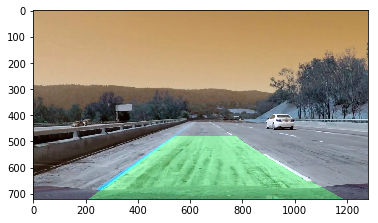

In [8]:
# Resetting class attributes
left_lane.reset()
right_lane.reset()
Sanity.reset()

plt.imshow(lane_detector(cv2.imread('Video Frame Images/frame560.jpg')))

## Project Video

In [9]:
# Resetting class attributes
left_lane.reset()
right_lane.reset()
Sanity.reset()

project_output = 'Project_Output_Videos/project_video_subclip_bad_stretch1.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4").subclip(20,25)
white_clip = clip1.fl_image(lane_detector) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

Sliding window being executed...
[MoviePy] >>>> Building video Project_Output_Videos/project_video_subclip_bad_stretch1.mp4
[MoviePy] Writing video Project_Output_Videos/project_video_subclip_bad_stretch1.mp4


  1%|          | 1/126 [00:00<00:28,  4.41it/s]

Sliding window being executed...


  2%|▏         | 2/126 [00:00<00:30,  4.13it/s]

Sliding window being executed...


  2%|▏         | 3/126 [00:00<00:30,  4.08it/s]

Sliding window being executed...


  3%|▎         | 4/126 [00:01<00:30,  4.01it/s]

Sliding window being executed...


  4%|▍         | 5/126 [00:01<00:30,  4.01it/s]

Sliding window being executed...


  5%|▍         | 6/126 [00:01<00:30,  3.93it/s]

Sliding window being executed...


  6%|▌         | 7/126 [00:01<00:30,  3.96it/s]

Sliding window being executed...


  6%|▋         | 8/126 [00:02<00:30,  3.90it/s]

Sliding window being executed...


  7%|▋         | 9/126 [00:02<00:29,  3.94it/s]

Sliding window being executed...


  8%|▊         | 10/126 [00:02<00:30,  3.84it/s]

Sliding window being executed...


  9%|▊         | 11/126 [00:02<00:29,  3.90it/s]

Sliding window being executed...


 10%|▉         | 12/126 [00:03<00:29,  3.86it/s]

Sliding window being executed...


 10%|█         | 13/126 [00:03<00:28,  3.91it/s]

Sliding window being executed...


 11%|█         | 14/126 [00:03<00:28,  3.87it/s]

Sliding window being executed...


 12%|█▏        | 15/126 [00:03<00:28,  3.88it/s]

Sliding window being executed...


 13%|█▎        | 16/126 [00:04<00:28,  3.84it/s]

Sliding window being executed...


 13%|█▎        | 17/126 [00:04<00:28,  3.88it/s]

Sliding window being executed...


 14%|█▍        | 18/126 [00:04<00:28,  3.85it/s]

Sliding window being executed...


 15%|█▌        | 19/126 [00:04<00:27,  3.88it/s]

Sliding window being executed...


 16%|█▌        | 20/126 [00:05<00:27,  3.85it/s]

Sliding window being executed...


 17%|█▋        | 21/126 [00:05<00:26,  3.91it/s]

Sliding window being executed...


 17%|█▋        | 22/126 [00:05<00:26,  3.85it/s]

Sliding window being executed...


 18%|█▊        | 23/126 [00:05<00:26,  3.92it/s]

Targeted Search being executed...


 19%|█▉        | 24/126 [00:06<00:26,  3.90it/s]

Targeted Search being executed...


 20%|█▉        | 25/126 [00:06<00:25,  3.94it/s]

Targeted Search being executed...


 21%|██        | 26/126 [00:06<00:25,  3.89it/s]

Sliding window being executed...


 21%|██▏       | 27/126 [00:06<00:25,  3.93it/s]

Sliding window being executed...


 22%|██▏       | 28/126 [00:07<00:25,  3.89it/s]

Sliding window being executed...


 23%|██▎       | 29/126 [00:07<00:24,  3.93it/s]

Sliding window being executed...


 24%|██▍       | 30/126 [00:07<00:24,  3.89it/s]

Targeted Search being executed...


 25%|██▍       | 31/126 [00:07<00:24,  3.93it/s]

Targeted Search being executed...


 25%|██▌       | 32/126 [00:08<00:24,  3.90it/s]

Sliding window being executed...


 26%|██▌       | 33/126 [00:08<00:23,  3.94it/s]

Sliding window being executed...


 27%|██▋       | 34/126 [00:08<00:23,  3.89it/s]

Sliding window being executed...


 28%|██▊       | 35/126 [00:08<00:23,  3.93it/s]

Sliding window being executed...


 29%|██▊       | 36/126 [00:09<00:23,  3.91it/s]

Sliding window being executed...


 29%|██▉       | 37/126 [00:09<00:22,  3.95it/s]

Sliding window being executed...


 30%|███       | 38/126 [00:09<00:22,  3.86it/s]

Sliding window being executed...


 31%|███       | 39/126 [00:10<00:22,  3.91it/s]

Targeted Search being executed...


 32%|███▏      | 40/126 [00:10<00:22,  3.87it/s]

Targeted Search being executed...


 33%|███▎      | 41/126 [00:10<00:21,  3.94it/s]

Sliding window being executed...


 33%|███▎      | 42/126 [00:10<00:21,  3.85it/s]

Sliding window being executed...


 34%|███▍      | 43/126 [00:11<00:28,  2.89it/s]

Sliding window being executed...


 35%|███▍      | 44/126 [00:11<00:28,  2.92it/s]

Targeted Search being executed...


 36%|███▌      | 45/126 [00:11<00:27,  2.96it/s]

Targeted Search being executed...


 37%|███▋      | 46/126 [00:12<00:27,  2.90it/s]

Sliding window being executed...


 37%|███▋      | 47/126 [00:12<00:26,  2.94it/s]

Sliding window being executed...


 38%|███▊      | 48/126 [00:13<00:26,  2.92it/s]

Targeted Search being executed...


 39%|███▉      | 49/126 [00:13<00:26,  2.93it/s]

Targeted Search being executed...


 40%|███▉      | 50/126 [00:13<00:25,  2.95it/s]

Targeted Search being executed...


 40%|████      | 51/126 [00:14<00:25,  2.98it/s]

Targeted Search being executed...


 41%|████▏     | 52/126 [00:14<00:24,  2.98it/s]

Targeted Search being executed...


 42%|████▏     | 53/126 [00:14<00:25,  2.90it/s]

Targeted Search being executed...


 43%|████▎     | 54/126 [00:15<00:24,  2.90it/s]

Targeted Search being executed...


 44%|████▎     | 55/126 [00:15<00:24,  2.93it/s]

Targeted Search being executed...


 44%|████▍     | 56/126 [00:15<00:24,  2.88it/s]

Sliding window being executed...


 45%|████▌     | 57/126 [00:16<00:23,  2.91it/s]

Sliding window being executed...


 46%|████▌     | 58/126 [00:16<00:23,  2.89it/s]

Sliding window being executed...


 47%|████▋     | 59/126 [00:16<00:23,  2.85it/s]

Sliding window being executed...


 48%|████▊     | 60/126 [00:17<00:22,  2.91it/s]

Sliding window being executed...


 48%|████▊     | 61/126 [00:17<00:24,  2.61it/s]

Targeted Search being executed...


 49%|████▉     | 62/126 [00:17<00:24,  2.67it/s]

Targeted Search being executed...


 50%|█████     | 63/126 [00:18<00:23,  2.71it/s]

Targeted Search being executed...


 51%|█████     | 64/126 [00:18<00:22,  2.79it/s]

Sliding window being executed...


 52%|█████▏    | 65/126 [00:19<00:21,  2.78it/s]

Sliding window being executed...


 52%|█████▏    | 66/126 [00:19<00:21,  2.84it/s]

Sliding window being executed...


 53%|█████▎    | 67/126 [00:19<00:20,  2.81it/s]

Sliding window being executed...


 54%|█████▍    | 68/126 [00:20<00:20,  2.88it/s]

Targeted Search being executed...


 55%|█████▍    | 69/126 [00:20<00:20,  2.85it/s]

Targeted Search being executed...


 56%|█████▌    | 70/126 [00:20<00:19,  2.88it/s]

Sliding window being executed...


 56%|█████▋    | 71/126 [00:21<00:19,  2.83it/s]

Sliding window being executed...


 57%|█████▋    | 72/126 [00:21<00:18,  2.88it/s]

Targeted Search being executed...


 58%|█████▊    | 73/126 [00:21<00:18,  2.83it/s]

Sliding window being executed...


 59%|█████▊    | 74/126 [00:22<00:18,  2.87it/s]

Sliding window being executed...


 60%|█████▉    | 75/126 [00:22<00:17,  2.84it/s]

Sliding window being executed...


 60%|██████    | 76/126 [00:22<00:17,  2.90it/s]

Sliding window being executed...


 61%|██████    | 77/126 [00:23<00:16,  2.91it/s]

Targeted Search being executed...


 62%|██████▏   | 78/126 [00:23<00:16,  2.91it/s]

Sliding window being executed...


 63%|██████▎   | 79/126 [00:23<00:15,  2.94it/s]

Targeted Search being executed...


 63%|██████▎   | 80/126 [00:24<00:15,  2.92it/s]

Targeted Search being executed...


 64%|██████▍   | 81/126 [00:24<00:15,  2.95it/s]

Targeted Search being executed...


 65%|██████▌   | 82/126 [00:24<00:15,  2.92it/s]

Targeted Search being executed...


 66%|██████▌   | 83/126 [00:25<00:15,  2.86it/s]

Targeted Search being executed...


 67%|██████▋   | 84/126 [00:25<00:14,  2.88it/s]

Targeted Search being executed...


 67%|██████▋   | 85/126 [00:25<00:14,  2.92it/s]

Targeted Search being executed...


 68%|██████▊   | 86/126 [00:26<00:13,  2.92it/s]

Targeted Search being executed...


 69%|██████▉   | 87/126 [00:26<00:13,  2.97it/s]

Targeted Search being executed...


 70%|██████▉   | 88/126 [00:26<00:12,  2.97it/s]

Targeted Search being executed...


 71%|███████   | 89/126 [00:27<00:12,  3.00it/s]

Targeted Search being executed...


 71%|███████▏  | 90/126 [00:27<00:11,  3.01it/s]

Targeted Search being executed...


 72%|███████▏  | 91/126 [00:27<00:11,  3.03it/s]

Targeted Search being executed...


 73%|███████▎  | 92/126 [00:28<00:11,  3.02it/s]

Targeted Search being executed...


 74%|███████▍  | 93/126 [00:28<00:10,  3.02it/s]

Targeted Search being executed...


 75%|███████▍  | 94/126 [00:28<00:10,  2.99it/s]

Targeted Search being executed...


 75%|███████▌  | 95/126 [00:29<00:10,  2.99it/s]

Targeted Search being executed...


 76%|███████▌  | 96/126 [00:29<00:10,  2.98it/s]

Targeted Search being executed...


 77%|███████▋  | 97/126 [00:29<00:09,  2.98it/s]

Targeted Search being executed...


 78%|███████▊  | 98/126 [00:30<00:09,  2.96it/s]

Targeted Search being executed...


 79%|███████▊  | 99/126 [00:30<00:09,  2.97it/s]

Targeted Search being executed...


 79%|███████▉  | 100/126 [00:30<00:08,  2.92it/s]

Targeted Search being executed...


 80%|████████  | 101/126 [00:31<00:08,  2.96it/s]

Targeted Search being executed...


 81%|████████  | 102/126 [00:31<00:08,  2.91it/s]

Targeted Search being executed...


 82%|████████▏ | 103/126 [00:31<00:07,  2.95it/s]

Targeted Search being executed...


 83%|████████▎ | 104/126 [00:32<00:07,  2.95it/s]

Targeted Search being executed...


 83%|████████▎ | 105/126 [00:32<00:07,  2.95it/s]

Targeted Search being executed...


 84%|████████▍ | 106/126 [00:33<00:06,  2.92it/s]

Targeted Search being executed...


 85%|████████▍ | 107/126 [00:33<00:06,  2.93it/s]

Targeted Search being executed...


 86%|████████▌ | 108/126 [00:33<00:06,  2.89it/s]

Targeted Search being executed...


 87%|████████▋ | 109/126 [00:34<00:05,  2.93it/s]

Targeted Search being executed...


 87%|████████▋ | 110/126 [00:34<00:05,  2.85it/s]

Targeted Search being executed...


 88%|████████▊ | 111/126 [00:34<00:05,  2.95it/s]

Targeted Search being executed...


 89%|████████▉ | 112/126 [00:35<00:04,  2.91it/s]

Targeted Search being executed...


 90%|████████▉ | 113/126 [00:35<00:04,  2.83it/s]

Targeted Search being executed...


 90%|█████████ | 114/126 [00:35<00:04,  2.81it/s]

Targeted Search being executed...


 91%|█████████▏| 115/126 [00:36<00:03,  2.93it/s]

Targeted Search being executed...


 92%|█████████▏| 116/126 [00:36<00:03,  2.88it/s]

Targeted Search being executed...


 93%|█████████▎| 117/126 [00:36<00:03,  2.93it/s]

Targeted Search being executed...


 94%|█████████▎| 118/126 [00:37<00:02,  2.87it/s]

Targeted Search being executed...


 94%|█████████▍| 119/126 [00:37<00:02,  2.56it/s]

Targeted Search being executed...


 95%|█████████▌| 120/126 [00:38<00:02,  2.52it/s]

Targeted Search being executed...


 96%|█████████▌| 121/126 [00:38<00:01,  2.58it/s]

Targeted Search being executed...


 97%|█████████▋| 122/126 [00:38<00:01,  2.71it/s]

Targeted Search being executed...


 98%|█████████▊| 123/126 [00:39<00:01,  2.74it/s]

Targeted Search being executed...


 98%|█████████▊| 124/126 [00:39<00:00,  2.76it/s]

Targeted Search being executed...


 99%|█████████▉| 125/126 [00:39<00:00,  2.75it/s]

Targeted Search being executed...


[MoviePy] Done.
[MoviePy] >>>> Video ready: Project_Output_Videos/project_video_subclip_bad_stretch1.mp4 

CPU times: user 23.7 s, sys: 5.48 s, total: 29.2 s
Wall time: 43.1 s


In [10]:
# Resetting class attributes
left_lane.reset()
right_lane.reset()
Sanity.reset()

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

## Challenge Video

In [ ]:
challenge_output = 'Project_Output_Videos/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("challenge_video.mp4")
white_clip = clip2.fl_image(lane_detector) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## HARDER CHALLENGE

In [ ]:
harder_challenge_output = 'Project_Output_Videos/harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip3 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip3.fl_image(lane_detector) #NOTE: this function expects color images!!
%time white_clip.write_videofile(harder_challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_output))

## MISC

In [ ]:
# def find_lane_pixels(binary_warped):

#     histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
#     out_img = np.dstack((binary_warped*255, binary_warped*255, binary_warped*255))
#     midpoint = np.int(histogram.shape[0]//2)
#     leftx_base = np.argmax((histogram[:midpoint]))
#     print(leftx_base)
#     rightx_base = np.argmax((histogram[midpoint:])) + midpoint
#     print(rightx_base)

#     # HYPERPARAMETERS
#     nwindows = 4
#     margin = 100
#     minpix = 100

#     window_height = np.int(binary_warped.shape[0]//nwindows)
#     nonzero = binary_warped.nonzero() # indices at which binar_warped has nonzero elements
#     nonzeroy = np.array(nonzero[0]) # indices of nonzero elements of 
#     # rows of binary_warped 
#     nonzerox = np.array(nonzero[1]) # indices of nonzero elements of colums
#     # of binary_warped
#     leftx_current = leftx_base
#     rightx_current = rightx_base

#     #Empty lists to receive left and right lane pixel indices
#     left_lane_inds = []
#     right_lane_inds = []

#     left_flag = 1
#     right_flag = 1

#     # Step through the left windows one by one
#     for window in range(nwindows):

#         if left_flag == 0:
#             break

#         win_y_low = binary_warped.shape[0] - (window+1)*window_height 
#         win_y_high = binary_warped.shape[0] - window*window_height
#         win_xleft_low = leftx_current - (margin) 
#         win_xleft_high = leftx_current + (margin)  

# #         cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 7) 

#         good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

#         left_lane_inds.append(good_left_inds)

#         if len(good_left_inds) > minpix:
#             leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
#         # Flag reset for high curvature lane ie lane out of frame    
#         if len(good_left_inds) == 0:
#             left_flag = 0

#     for window in range(nwindows):
#         if right_flag == 0:
#             break

#         win_y_low = binary_warped.shape[0] - (window+1)*window_height
#         win_y_high = binary_warped.shape[0] - window*window_height
#         win_xright_low = rightx_current - (margin) 
#         win_xright_high = rightx_current + (margin) 

# #         cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 7) 

#         good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

#         right_lane_inds.append(good_right_inds)

#         if len(good_right_inds) > minpix:
#             rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
#         # Flag reset for large curvature lane ie lane out of frame
#         if len(good_right_inds) == 0:
#             right_flag = 0   

#     # Concatenate the arrays of indices (previously was a list of lists of pixels)
#     try:
#         left_lane_inds = np.concatenate(left_lane_inds)
#         right_lane_inds = np.concatenate(right_lane_inds)
#     except ValueError:
#         pass

#     leftx = nonzerox[left_lane_inds]
#     lefty = nonzeroy[left_lane_inds] 
#     rightx = nonzerox[right_lane_inds]
#     righty = nonzeroy[right_lane_inds]

#     return leftx, lefty, rightx, righty, out_img

# def fit_polynomial(binary_warped):
#     # Find our lane pixels first
#     leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

#     ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
#     left_fit = np.polyfit(lefty,leftx,2)
#     right_fit = np.polyfit(righty,rightx,2)

#     # Generate x and y values for plotting
#     ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#     try:
#         left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#         right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
#         fit_flag = 0
#     except TypeError:
#         # Avoids an error if `left` and `right_fit` are still none or incorrect
#         print('The function failed to fit a line!')
#         fit_flag = 1
#         left_fitx = 1*ploty**2 + 1*ploty
#         right_fitx = 1*ploty**2 + 1*ploty

# #         ## Visualization ##
# #     # Create an image to draw on and an image to show the selection window
# #     window_img = np.zeros_like(out_img)
# #     # Color in left and right line pixels
# #     out_img[lefty, leftx] = [255, 0, 0]
# #     out_img[righty, rightx] = [0, 0, 255]
    
# #     # Generate a polygon to illustrate the search window area
# #     # And recast the x and y points into usable format for cv2.fillPoly()    
# #     left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
# #     right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
# #                               ploty])))])
# #     lane_line_pts = np.hstack((left_line, right_line))
    
# #     # Draw the lane onto the warped blank image
# #     cv2.fillPoly(window_img, np.int_([lane_line_pts]), (0,255, 0))
# #     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

#     return left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty

# left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty = fit_polynomial(npersp_trans(sthresh(calibrator(cv2.imread('Video Frame Images/frame577.jpg')))))

#     ## Visualization ##
# # Create an image to draw on and an image to show the selection window
# window_img = np.zeros_like(ctest[3])
# # Generate a polygon to illustrate the lane
# # And recast the x and y points into usable format for cv2.fillPoly()    
# left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
# right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
#                           ploty])))])
# lane_line_pts = np.hstack((left_line, right_line))

# # Draw the lane onto the warped blank image
# cv2.fillPoly(window_img, np.int_([lane_line_pts]), (0,255, 0))
# # Color lane line pixels
# # window_img[lefty, leftx] = [255, 0, 0]
# # window_img[righty, rightx] = [0, 0, 255]


# result = cv2.addWeighted(ctest[3], 1, ninv_persp_trans(window_img), 0.3, 0)
# plt.imshow(result)

# # plt.imshow(fit_polynomial(persp_trans(sthresh(calibrator(ctest[3])))))

# #         ## Visualization ##
# #     # Create an image to draw on and an image to show the selection window
# #     out_img = np.dstack((img, img, img))*255
# #     window_img = np.zeros_like(out_img)
# #     # Color in left and right line pixels
# #     out_img[lefty, leftx] = [255, 0, 0]
# #     out_img[righty, rightx] = [0, 0, 255]
    
# #     # Generate a polygon to illustrate the search window area
# #     # And recast the x and y points into usable format for cv2.fillPoly()    
# #     left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
# #     right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, 
# #                               ploty])))])
# #     lane_line_pts = np.hstack((left_line, right_line))
    
# #     # Draw the lane onto the warped blank image
# #     cv2.fillPoly(window_img, np.int_([lane_line_pts]), (0,255, 0))
# #     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        